# 第13章 ニューラルネットワークの訓練をTensorFlowで並列化する

## 13.1 TensorFlow と訓練の性能

TensorFlowを利用すれば、機械学習のタスクを大幅に高速化できる。

## 13.2 TensorFlow: 最初のステップ

### 13.2.1 TensorFlow のインストール

`tf.convert_to_tensor`関数では、リストまたはNumPy配列からテンソルを作成できる。

In [1]:
import tensorflow as tf
import numpy as np
np.set_printoptions(precision=3)
a = np.array([1, 2, 3], dtype=np.int32)
b = [4, 5, 6]
t_a = tf.convert_to_tensor(a)
t_b = tf.convert_to_tensor(b)
print(t_a)
print(t_b)

2024-11-20 10:44:31.534500: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf.Tensor([1 2 3], shape=(3,), dtype=int32)
tf.Tensor([4 5 6], shape=(3,), dtype=int32)


In [4]:
t_ones = tf.ones((2,3))
t_ones.shape

TensorShape([2, 3])

テンソルが参照している値にアクセスしたい場合は、単にテンソルでnumpyメゾットを呼び出す。

In [5]:
t_ones.numpy()

array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

最後に、定数値のテンソルを作成する方法は次のようになる。

In [7]:
const_tensor = tf.constant([1.2, 5, np.pi], dtype=tf.float32)
print(const_tensor)

tf.Tensor([1.2   5.    3.142], shape=(3,), dtype=float32)


### 13.2.3 テンソルのデータ型と形状を操作する

`tf.cast`関数を使うと、テンソルのデータ型を目的のデータ型に変更できる。

In [8]:
t_a_new = tf.cast(t_a, tf.int64)
print(t_a_new.dtype)

<dtype: 'int64'>


**テンソルの転置**

In [9]:
t = tf.random.uniform(shape=(3, 5))
t_tr = tf.transpose(t)
print(t.shape, ' --> ', t_tr.shape)

(3, 5)  -->  (5, 3)


**テンソルの形状変更**

In [10]:
t = tf.zeros((30,))
t_reshape = tf.reshape(t, shape=(5, 6))
print(t_reshape.shape)

(5, 6)


**不要な次元の削除（サイズが1の次元の不要なものを削除）**

In [12]:
t = tf.zeros((1, 2, 1, 4, 1))
t_sqz = tf.squeeze(t, axis=(2, 4))
print(t.shape, ' --> ', t_sqz.shape)

(1, 2, 1, 4, 1)  -->  (1, 2, 4)


### 13.2.4 テンソルでの算術演算

ランダムなテンソルを2つをインスタンス化する。<br>
1つは[-1, 1)の範囲の一様分布のテンソルであり、もう1つは標準正規分布のテンソルである。

In [2]:
tf.random.set_seed(1)
t1 = tf.random.uniform(shape=(5, 2), minval=-1.0, maxval=1.0)
t2 = tf.random.normal(shape=(5, 2), mean=0.0, stddev=1.0)

`t1`と`t2`の形状が同じである。<br>
`t1`と`t2`の要素ごとの積を求めるために次のコードを実行する。

In [4]:
t3 = tf.multiply(t1, t2).numpy()
print(t3)

[[-0.27  -0.874]
 [-0.017 -0.175]
 [-0.296 -0.139]
 [-0.727  0.135]
 [-0.401  0.004]]


特定の（1つ以上の）軸に沿って平均、総和、標準偏差をもとめるためには、`tf.math.reduce_mean()`, `tf.math.reduce_sum()`, `tf.math.reduce_std()`を使う

`t1`の各列の平均

In [5]:
t4 = tf.math.reduce_mean(t1, axis=0)
print(t4)

tf.Tensor([0.09  0.207], shape=(2,), dtype=float32)


`t1`と`t2`の行列と行列の積 ― つまり、$t_{1} \times t_{2}^{\mathrm{T}}$ ($\mathrm{T}$は転置) ― を求めるには、`tf.linalg.matmul()`を使う

In [6]:
t5 = tf.linalg.matmul(t1, t2, transpose_b=True)
print(t5.numpy())

[[-1.144  1.115 -0.87  -0.321  0.856]
 [ 0.248 -0.191  0.25  -0.064 -0.331]
 [-0.478  0.407 -0.436  0.022  0.527]
 [ 0.525 -0.234  0.741 -0.593 -1.194]
 [-0.099  0.26   0.125 -0.462 -0.396]]


これに対し、$t_{1}^{\mathrm{T}} \times t_{2}$は`t1`の転置によって求められ、結果は$2 \times 2$の配列になる。

In [7]:
t6 = tf.linalg.matmul(t1, t2, transpose_a=True)
print(t6.numpy())

[[-1.711  0.302]
 [ 0.371 -1.049]]


`tf.norm()`では、テンソルの$L^{p}$ノルムを計算できる。<br>
例えば、`t1`の$L^{2}$ノルムの計算は次のようになる。

In [8]:
norm_t1 = tf.norm(t1, ord=2, axis=1).numpy()
print(norm_t1)

[1.046 0.293 0.504 0.96  0.383]


NumPy関数`np.sqrt(np.sum(np.square(t1), axis=1))`の結果と比較すると良い

### 13.2.5 テンソルの分割、積み上げ、連結

TensorFlowの演算のうち、テンソルを複数のテンソルに分割する演算、逆に、複数のテンソルを1つのテンソルに積み上げる演算や連結する演算を取り上げる。

テンソルが1つだけで、2つ以上のテンソルに分割させるための便利な関数`tf.split()`が定義されている。

入力テンソルを同じサイズの複数のテンソルに分割する。

テンソルの分割数は`num_or_size_splits`パラメータを使って整数で指定できる。

テンソルは`axis`パラメータで指定された軸に沿って分割される。

**同じサイズでの分割（指定された数で割り切れなければならない）**

tf.random.set_seed(1)
t = tf.random.uniform((6,))
print(t.numpy())

In [4]:
t_splits = tf.split(t, num_or_size_splits=3)
[item.numpy() for item in t_splits]

[array([0.165, 0.901], dtype=float32),
 array([0.631, 0.435], dtype=float32),
 array([0.292, 0.643], dtype=float32)]

この例では、サイズ6のテンソルをサイズ2の3つのテンソルからなるリストに分割している。

**異なるサイズでの分割**

分割数を指定する代わりに、出力テンソルのサイズを直接指定することもできる。<br>
サイズ5のテンソルをサイズ3とサイズ2のテンソルに分割している。

In [6]:
tf.random.set_seed(1)
t = tf.random.uniform((5,))
print(t.numpy())

[0.165 0.901 0.631 0.435 0.292]


In [7]:
t_splits = tf.split(t, num_or_size_splits=[3, 2])
[item.numpy() for item in t_splits]

[array([0.165, 0.901, 0.631], dtype=float32),
 array([0.435, 0.292], dtype=float32)]

複数のテンソルを扱っていて、それらを連結または積み上げて1つのテンソルにしなければならないこともある。<br>
このような場合は、`tf.stack()`や`tf.concat()`が便利である。

In [2]:
A = tf.ones((3,))
B = tf.zeros((2,))
C = tf.concat([A, B], axis=0)
print(C.numpy())

[1. 1. 1. 0. 0.]


In [3]:
A = tf.ones((3,))
B = tf.zeros((3,))
S = tf.stack([A, B], axis=1)
print(S.numpy())

[[1. 0.]
 [1. 0.]
 [1. 0.]]


## 13.3 tf.data を使った入力パイプラインの構築：TensorFlow Dataset API

TensorFlowには、効率的で便利な前処理パイプラインを構築するための特別なクラスが定義されている。

### 13.3.1 TensorFlowのDatasetを既存のテンソルから作成する

データがテンソルオブジェクト、Pythonリスト、またはNumpy配列としてすでに存在している場合は、`tf.data.Dataset.from_tensor_slices`メゾットを使ってデータセットを簡単に作成できる。この関数は`Dataset`クラスのオブジェクトを返す。

In [3]:
a = [1.2, 3.4, 7.5, 4.1, 5.0, 1.0]
ds = tf.data.Dataset.from_tensor_slices(a)
print(ds)

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>


このデータセットから、例えばサイズが3のバッチを作成したい場合は、次のようになる。

In [4]:
ds_batch = ds.batch(3)
for i, elem in enumerate(ds_batch, 1):
    print("batch {}:".format(i), elem.numpy())

batch 1: [1.2 3.4 7.5]
batch 2: [4.1 5.  1. ]


2024-11-14 13:21:33.785839: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 13.3.2 2つのテンソルを1つのデータセットに結合する

`t_x`と`t_y`の2つのテンソルがあるとする。<br>
テンソル`t_x`は特徴量の値を含んでおり、それぞれの値のサイズは3である。<br>
テンソル`t_y`はクラスラベルを含んでいる。

In [5]:
tf.random.set_seed(1)
t_x = tf.random.uniform([4, 3], dtype=tf.float32)
t_y = tf.range(4)

これら2つのテンソルから結合データセットを作成したい。

In [6]:
ds_x = tf.data.Dataset.from_tensor_slices(t_x)
ds_y = tf.data.Dataset.from_tensor_slices(t_y)

ds_joint = tf.data.Dataset.zip((ds_x, ds_y))
for example in ds_joint:
    print(" x:", example[0].numpy(), " y:", example[1].numpy())

 x: [0.165 0.901 0.631]  y: 0
 x: [0.435 0.292 0.643]  y: 1
 x: [0.976 0.435 0.66 ]  y: 2
 x: [0.605 0.637 0.614]  y: 3


2024-11-14 13:21:38.926786: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
ds_joint = tf.data.Dataset.from_tensor_slices((t_x, t_y))
for example in ds_joint:
    print(" x:", example[0].numpy(), " y:", example[1].numpy())

 x: [0.165 0.901 0.631]  y: 0
 x: [0.435 0.292 0.643]  y: 1
 x: [0.976 0.435 0.66 ]  y: 2
 x: [0.605 0.637 0.614]  y: 3


データセットの各要素に変換を適用する方法を見てみよう。

In [8]:
ds_trans = ds_joint.map(lambda x, y: (x*2-1.0, y))
for example in ds_trans:
    print(" x:", example[0].numpy(), " y:", example[1].numpy())

 x: [-0.67   0.803  0.262]  y: 0
 x: [-0.131 -0.416  0.285]  y: 1
 x: [ 0.952 -0.13   0.32 ]  y: 2
 x: [0.21  0.273 0.229]  y: 3


2024-11-14 13:21:40.536675: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 13.3.3 シャッフル、バッチ、リピート

バッチの作成に加えて、データセットのシャッフルとリピートの方法を確認する。

まず、`ds_joint`データセットのシャッフルバージョンを作成する。

In [9]:
tf.random.set_seed(1)
ds = ds_joint.shuffle(buffer_size=len(t_x))
for example in ds:
    print(" x:", example[0].numpy(), " y:", example[1].numpy())

 x: [0.976 0.435 0.66 ]  y: 2
 x: [0.435 0.292 0.643]  y: 1
 x: [0.165 0.901 0.631]  y: 0
 x: [0.605 0.637 0.614]  y: 3


エポックごとに完全なランダム性を確保するために`buffer_size`を訓練データの個数と同じ値にしてもよいだろう。

`ds_joint`データセットからバッチを作成し、どのようなバッチが作成されるか調べよう。

In [10]:
ds = ds_joint.batch(batch_size=3, drop_remainder=False)
batch_x, batch_y = next(iter(ds))
print("Batch-x:\n", batch_x.numpy())
print("Batch-y: ", batch_y.numpy())

Batch-x:
 [[0.165 0.901 0.631]
 [0.435 0.292 0.643]
 [0.976 0.435 0.66 ]]
Batch-y:  [0 1 2]


複数のエポックでモデル訓練するときは、目的のエポックの回数に基づいてデータセットのシャッフル/リピートを行う。

In [11]:
ds = ds_joint.batch(3).repeat(count=2)
for i, (batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (3, 3) [0 1 2]
1 (1, 3) [3]
2 (3, 3) [0 1 2]
3 (1, 3) [3]


In [12]:
ds = ds_joint.repeat(count=2).batch(3)
for i, (batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (3, 3) [0 1 2]
1 (3, 3) [3 0 1]
2 (2, 3) [2 3]


シャッフル、バッチ、リピートの順に実行した場合

In [13]:
tf.random.set_seed(1)
ds = ds_joint.shuffle(4).batch(2).repeat(3)
for i, (batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (2, 3) [2 1]
1 (2, 3) [0 3]
2 (2, 3) [0 3]
3 (2, 3) [1 2]
4 (2, 3) [3 0]
5 (2, 3) [1 2]


2024-11-14 13:29:48.653491: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


バッチ、シャッフル、リピートの順に実行した場合

In [14]:
tf.random.set_seed(1)
ds = ds_joint.batch(2).shuffle(4).repeat(3)
for i, (batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (2, 3) [0 1]
1 (2, 3) [2 3]
2 (2, 3) [0 1]
3 (2, 3) [2 3]
4 (2, 3) [2 3]
5 (2, 3) [0 1]


### 13.3.4 ローカルディスク上のファイルからデータセットを作成する

イヌとネコの6つの画像 (JPEGフォーマット)を表示するコードを作成する<br>
画像ファイルの内容を読み込むために`tf.io`モジュールを使い、画像をデコード・サイズ変更するために`tf.image`モジュールを使う。

コマンドからS3バケットにファイルをアップロードした。

matplotlibを使ってイヌとネコの画像を可視化する。

In [4]:
import matplotlib.pyplot as plt
import os
import boto3
import sagemaker
import io

bucket = sagemaker.Session().default_bucket()

s3 = boto3.resource("s3")
bucket_photos = s3.Bucket(bucket)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
cat_dog_images/cat-01.jpg
Image shape:  (900, 1200, 3)
cat_dog_images/cat-02.jpg
Image shape:  (900, 1200, 3)
cat_dog_images/cat-03.jpg
Image shape:  (900, 742, 3)
cat_dog_images/dog-01.jpg
Image shape:  (800, 1200, 3)
cat_dog_images/dog-02.jpg
Image shape:  (800, 1200, 3)
cat_dog_images/dog-03.jpg
Image shape:  (900, 1200, 3)


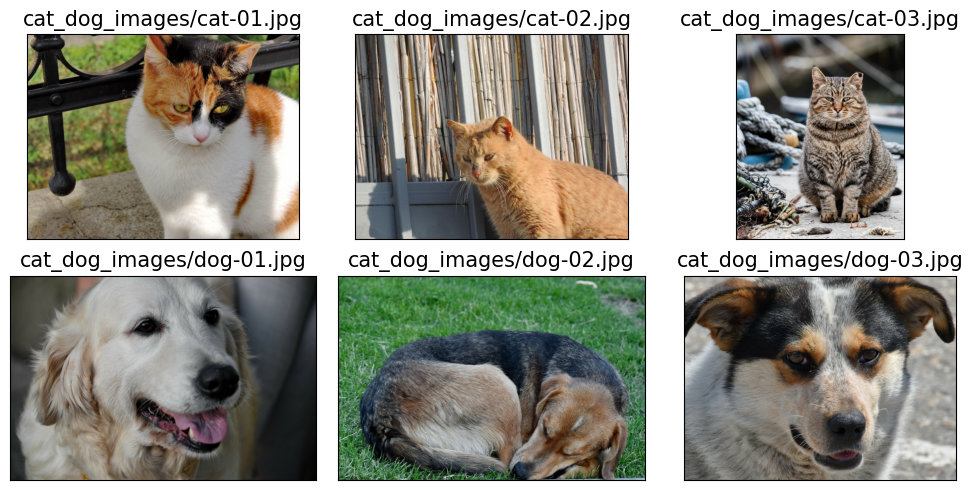

In [2]:
fig = plt.figure(figsize=(10, 5))

for (i, obj) in enumerate(bucket_photos.objects.filter(Prefix="cat_dog_images")):
    print(obj.key)
    with open(obj.key, "wb") as f:
        bucket_photos.download_fileobj(obj.key, f)

    img_raw = tf.io.read_file(obj.key)
    img = tf.io.decode_jpeg(img_raw)
    print("Image shape: ", img.shape)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img)

    ax.set_title(obj.key, size=15)

plt.tight_layout()
plt.show()

画像のアスペクト比が異なっている。

画像サイズを統一するために前処理を行う。

画像のラベルをファイル名のリストから抽出し、イヌにラベル1、ネコにラベル0を割り当てる。

In [5]:
file_list = sorted(["images/" + filepath.key for filepath in bucket_photos.objects.filter(Prefix="cat_dog_images")])

In [6]:
print(file_list)

['images/cat_dog_images/cat-01.jpg', 'images/cat_dog_images/cat-02.jpg', 'images/cat_dog_images/cat-03.jpg', 'images/cat_dog_images/dog-01.jpg', 'images/cat_dog_images/dog-02.jpg', 'images/cat_dog_images/dog-03.jpg']


In [7]:
labels = [1 if "dog" in os.path.basename(filepath) else 0 for filepath in file_list]

In [8]:
print(labels)

[0, 0, 0, 1, 1, 1]


リストが2つになった。<br>
1つはファイル名（各画像のパス）からなるリストであり、もう1つは画像のラベルからなるリストである。<br>
2つのテンソルから結合データセットを作成する

In [9]:
ds_files_labels = tf.data.Dataset.from_tensor_slices((file_list, labels))
for item in ds_files_labels:
    print(item[0].numpy(), item[1].numpy())

b'images/cat_dog_images/cat-01.jpg' 0
b'images/cat_dog_images/cat-02.jpg' 0
b'images/cat_dog_images/cat-03.jpg' 0
b'images/cat_dog_images/dog-01.jpg' 1
b'images/cat_dog_images/dog-02.jpg' 1
b'images/cat_dog_images/dog-03.jpg' 1


2024-11-20 10:46:12.472413: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


ファイルパスから画像を読み込み、その内容をデコードし、目的のサイズ(80×120)に変更する。

2024-11-20 10:46:29.583210: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


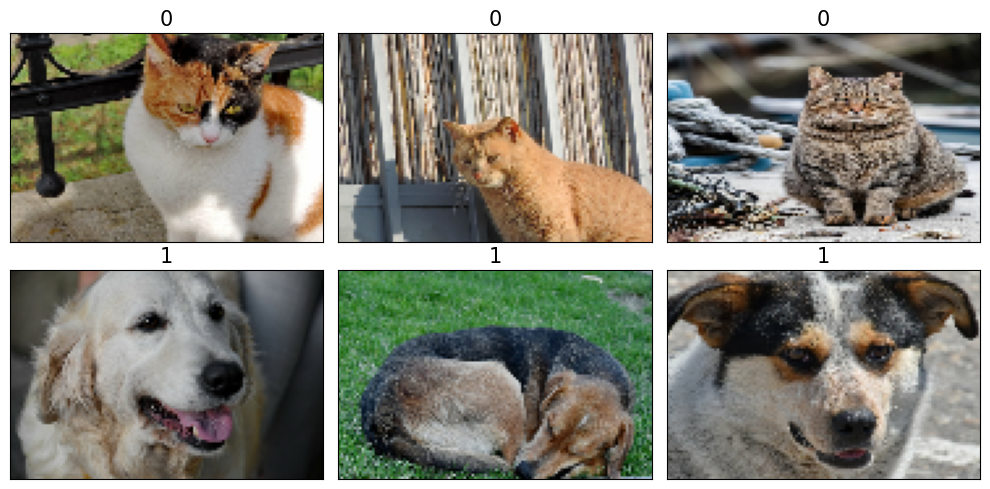

In [11]:
def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image /= 255.0
    return image, label

img_width, img_height = 120, 80
ds_files_labels = ds_files_labels.map(load_and_preprocess)

fig = plt.figure(figsize=(10, 5))

for i, example in enumerate(ds_files_labels):
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])
    ax.set_title("{}".format(example[1].numpy()), size=15)

plt.tight_layout()
plt.show()

### 13.3.5 tensorflow_datasetsライブラリからデータセットを取り出す

In [2]:
%pip install tensorflow-datasets

  Using cached tensorflow_datasets-4.9.7-py3-none-any.whl.metadata (9.6 kB)
  Using cached dm_tree-0.1.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached immutabledict-4.2.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached promise-2.3-py3-none-any.whl
  Using cached simple_parsing-0.1.6-py3-none-any.whl.metadata (7.3 kB)
  Using cached tensorflow_metadata-1.16.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached array_record-0.5.1-1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (699 bytes)
  Using cached etils-1.10.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached docstring_parser-0.16-py3-none-any.whl.metadata (3.0 kB)
Using cached tensorflow_datasets-4.9.7-py3-none-any.whl (5.3 MB)
Using cached array_record-0.5.1-1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (2.2 MB)
Using cached etils-1.10.0-py3-none-any.whl (164 kB)
Using cached dm_tree

In [3]:
import tensorflow_datasets as tfds
print(len(tfds.list_builders()))

2024-11-21 12:54:31.471026: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 12:54:36.840430: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".


1296


In [4]:
print(tfds.list_builders()[:5])

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset']


ここでは、`CelebA`と`MNIST`の2つのデータセットを取り出す。

データセットを取り出す方法は2つある。

1. データセットの`builder`関数を呼び出す
2. `download_and_prepare`メゾットを呼び出す
3. `as_dataset`メゾットを呼び出す

`CelebA`データセットで最初の手順を実行し、`tensorflow_datasets`ライブラリに含まれているデータセットの説明を出力する

In [3]:
celeba_bldr = tfds.builder("celeb_a")
print(celeba_bldr.info.features)

FeaturesDict({
    'attributes': FeaturesDict({
        '5_o_Clock_Shadow': bool,
        'Arched_Eyebrows': bool,
        'Attractive': bool,
        'Bags_Under_Eyes': bool,
        'Bald': bool,
        'Bangs': bool,
        'Big_Lips': bool,
        'Big_Nose': bool,
        'Black_Hair': bool,
        'Blond_Hair': bool,
        'Blurry': bool,
        'Brown_Hair': bool,
        'Bushy_Eyebrows': bool,
        'Chubby': bool,
        'Double_Chin': bool,
        'Eyeglasses': bool,
        'Goatee': bool,
        'Gray_Hair': bool,
        'Heavy_Makeup': bool,
        'High_Cheekbones': bool,
        'Male': bool,
        'Mouth_Slightly_Open': bool,
        'Mustache': bool,
        'Narrow_Eyes': bool,
        'No_Beard': bool,
        'Oval_Face': bool,
        'Pale_Skin': bool,
        'Pointy_Nose': bool,
        'Receding_Hairline': bool,
        'Rosy_Cheeks': bool,
        'Sideburns': bool,
        'Smiling': bool,
        'Straight_Hair': bool,
        'Wavy_Hair': b

In [5]:
print(celeba_bldr.info.features["image"])

Image(shape=(218, 178, 3), dtype=uint8)


In [6]:
print(celeba_bldr.info.features["attributes"].keys())

dict_keys(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'])


In [7]:
print(celeba_bldr.info.citation)

@inproceedings{conf/iccv/LiuLWT15,
  added-at = {2018-10-09T00:00:00.000+0200},
  author = {Liu, Ziwei and Luo, Ping and Wang, Xiaogang and Tang, Xiaoou},
  biburl = {https://www.bibsonomy.org/bibtex/250e4959be61db325d2f02c1d8cd7bfbb/dblp},
  booktitle = {ICCV},
  crossref = {conf/iccv/2015},
  ee = {http://doi.ieeecomputersociety.org/10.1109/ICCV.2015.425},
  interhash = {3f735aaa11957e73914bbe2ca9d5e702},
  intrahash = {50e4959be61db325d2f02c1d8cd7bfbb},
  isbn = {978-1-4673-8391-2},
  keywords = {dblp},
  pages = {3730-3738},
  publisher = {IEEE Computer Society},
  timestamp = {2018-10-11T11:43:28.000+0200},
  title = {Deep Learning Face Attributes in the Wild.},
  url = {http://dblp.uni-trier.de/db/conf/iccv/iccv2015.html#LiuLWT15},
  year = 2015
}


特徴量は`image`、`landmarks`、`attributes`の3つのキーを持つディレクトリとして格納されている。<br>
`image`はセレブの顔写真、`landmarks`は目や鼻などの位置といった顔の特徴点からなるディクショナリ、`attributes`は画像の人物の表情、メイク、髪質といった40種類の顔属性からなるディクショナリである。

次に、`download_and_prepare`メゾットの呼び出し

In [ ]:
celeba_bldr.download_and_prepare()

MNISTデータセットを取得する方法

In [5]:
mnist, mnist_info = tfds.load("mnist", with_info=True, shuffle_files=False)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /home/sagemaker-user/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
print(mnist_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/home/sagemaker-user/tensorflow_datasets/mnist/incomplete.ST0ZTJ_3.0.1/',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year

print(mnist.keys())

訓練サブセットを取り出し、訓練サブセットのデータをディクショナリからタプルに変換し、10個のデータ点を可視化する。

In [8]:
ds_train = mnist["train"]
ds_train = ds_train.map(lambda item: (item["image"], item["label"]))
ds_train = ds_train.batch(10)
batch = next(iter(ds_train))
print(batch[0].shape, batch[1])

(10, 28, 28, 1) tf.Tensor([4 1 0 7 8 1 2 7 1 6], shape=(10,), dtype=int64)


2024-11-21 13:00:15.235318: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


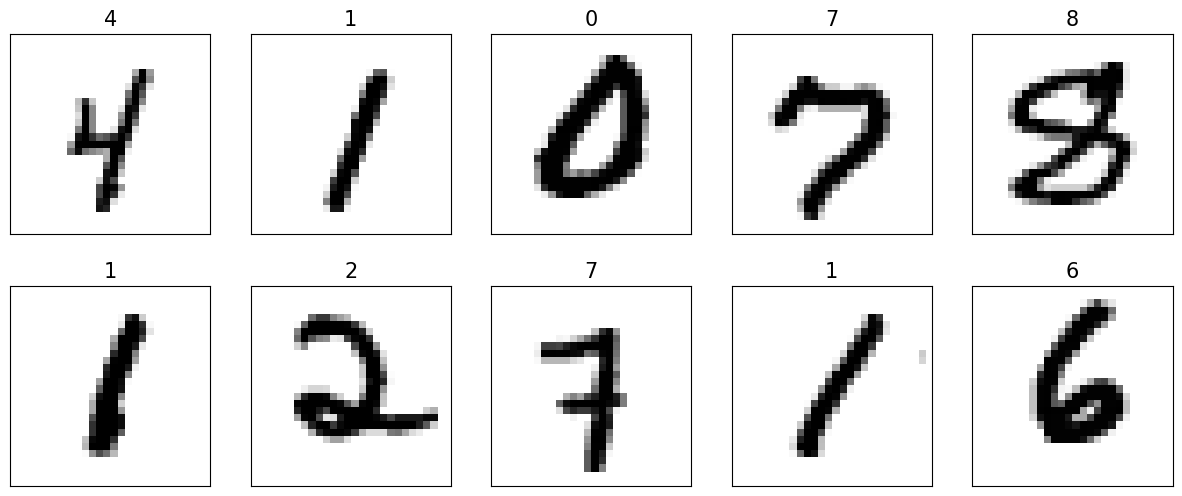

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 6))
for i, (image, label) in enumerate(zip(batch[0], batch[1])):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image[:, :, 0], cmap="gray_r")
    ax.set_title("{}".format(label), size=15)
plt.show()

## 13.4 TensorFlowでのニューラルネットワークモデルの構築

### 13.4.1 TensorFlow Keras API (tf.keras)

`tf.keras`モジュールを使ってニューラルネットワークモデルを構築する

TensorFlowでニューラルネットワークを構築するための最も一般的なアプローチは`tf.keras.Sequential`を使った層の積み上げである。

`tf.keras`では、モデルを`tf.keras.Model`のサブクラスとして定義することもできる。<br>
`call`メゾットをモデルクラスに定義することで、フォワードパスをより厳密に制御できる。

### 13.4.2 線形回帰モデルを構築する

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.src.initializers import Zeros

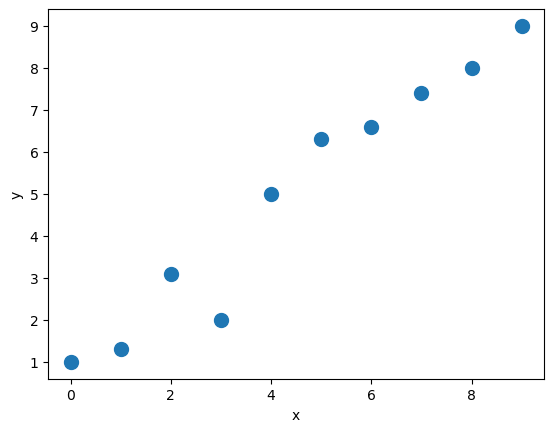

In [2]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])
plt.plot(X_train, y_train, "o", markersize=10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

次に、特徴量を標準化し（平均で中心化し、標準偏差で割る）、TensorFlowの`Detaset`オブジェクトを作成する。

In [3]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32), tf.cast(y_train, tf.float32))
)

線形回帰モデルは$z=wx+b$として定義できる。<br>
ここでは、TensorFlow Keras APIを使うことにする。

`tf.keras.Model`クラスを継承する新しいクラスを定義する。<br>

`tf.keras.Model`クラスを継承する新しいクラスを定義する。<br>
`tf.keras.Model`をサブクラス化すると、モデルの調査、訓練、評価に`Keras`のツールを利用できるようになる。

In [8]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.w = tf.keras.Variable(0.0, name="weight")
        self.b = tf.keras.Variable(0.0, name="bias")

    def call(self, x):
        return self.w * x + self.b

次に、`MyModel`クラスから新しいモデルをインスタンス化し、訓練データを使って訓練する。<br>
`model.build()`を呼び出し、引数として入力データを期待する形状を指定する。

In [9]:
model = MyModel()
model.build(input_shape=(None, 1))
model.summary()

Model: "my_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

`model.build()`の呼び出しで、期待される入力テンソルの1次元目のプレースホルダとして`None`を使っている点に注意。<br>
このようにすると、任意のバッチサイズを使えるようになる。<br>
ただし、特徴量の個数は固定である。（この場合は1）<br>
インスタンス化の後に`build`メゾットを呼び出してモデルの層とパラメータを構築することを**遅延変数作成**という。

コスト関数として**平均二乗誤差**(MSE)を選択する。

重みパラメータの学習には、**確率的勾配降下法**を使う。

勾配の計算には、TensorFlowの`tf.GradientTape`を使うことにする。

In [10]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

ハイパーパラメータを設定し、モデルを200エポックで訓練できる。データセットのバッチバージョンを作成し、このデータセットに対して`count=None`でリピートを行う。

In [11]:
tf.random.set_seed(1)
num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))

ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(1)
Ws, bs = [], []

for i, batch in enumerate(ds_train):
    if i >= steps_per_epoch * num_epochs:
        break # 無限ループを抜ける
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model(bx), by)

    train(model, bx, by, learning_rate=learning_rate)
    if i%log_steps==0:
        print("Epochs {:4d} Steps {:2d} Loss {:6.4f}".format(int(i/steps_per_epoch), i, loss_val))

Epochs    0 Steps  0 Loss 43.5600
Epochs   10 Steps 100 Loss 0.7530
Epochs   20 Steps 200 Loss 20.1759
Epochs   30 Steps 300 Loss 23.3976
Epochs   40 Steps 400 Loss 6.3481
Epochs   50 Steps 500 Loss 4.6356
Epochs   60 Steps 600 Loss 0.2411
Epochs   70 Steps 700 Loss 0.2036
Epochs   80 Steps 800 Loss 3.8177
Epochs   90 Steps 900 Loss 0.9416
Epochs  100 Steps 1000 Loss 0.7035
Epochs  110 Steps 1100 Loss 0.0348
Epochs  120 Steps 1200 Loss 0.5404
Epochs  130 Steps 1300 Loss 0.1170
Epochs  140 Steps 1400 Loss 0.1195
Epochs  150 Steps 1500 Loss 0.0944
Epochs  160 Steps 1600 Loss 0.4670
Epochs  170 Steps 1700 Loss 2.0695
Epochs  180 Steps 1800 Loss 0.0020
Epochs  190 Steps 1900 Loss 0.3612


訓練したモデルを調べてプロットする。<br>
モデルの訓練には標準化された特徴量を使ったために、テストデータにも同じ標準化を適用する。

In [12]:
print("Final Parameters: ", model.w.numpy(), model.b.numpy())

Final Parameters:  2.6576622 4.8798566


In [13]:
X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))

訓練データと訓練された線形回帰モデルの散布図と、重み$w$、バイアスユニット$b$の収束履歴を示す

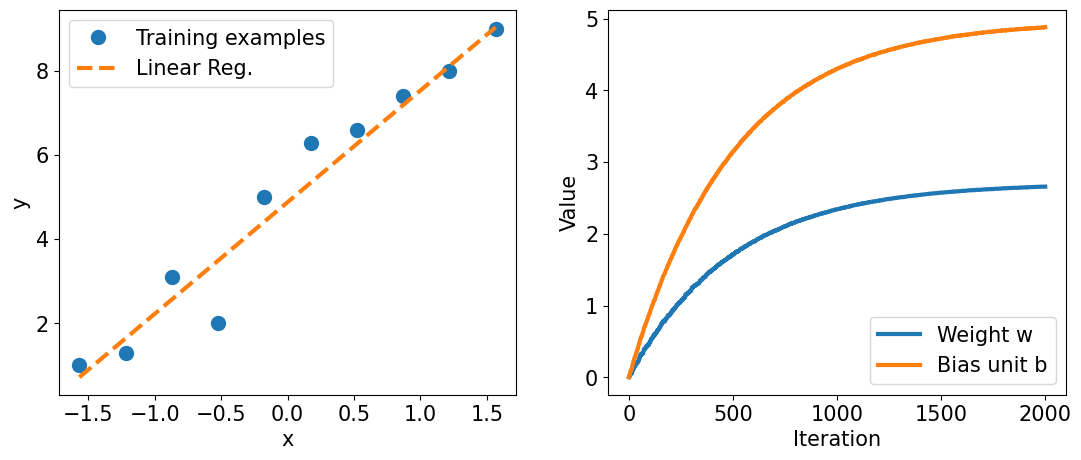

In [14]:
fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, "o", markersize=10)
plt.plot(X_test_norm, y_pred, "--", lw=3)
plt.legend(["Training examples", "Linear Reg."], fontsize=15)
ax.set_xlabel("x", size=15)
ax.set_ylabel("y", size=15)
ax.tick_params(axis="both", which="major", labelsize=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(["Weight w", "Bias unit b"], fontsize=15)
ax.set_xlabel("Iteration", size=15)
ax.set_ylabel("Value", size=15)
ax.tick_params(axis="both", which="major", labelsize=15)
plt.show()

### 13.4.3 compile と fit を使ってモデルを訓練する

In [15]:
tf.random.set_seed(1)
model = MyModel()
model.compile(optimizer="sgd", loss=loss_fn, metrics=["mae", "mse"])

In [16]:
model.fit(X_train_norm, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 24.1936 - mae: 4.2272 - mse: 24.1936
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3219 - mae: 3.4892 - mse: 16.3219
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.0623 - mae: 2.8868 - mse: 11.0623
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5438 - mae: 2.3950 - mse: 7.5438 
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1866 - mae: 2.0062 - mse: 5.1866 
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6047 - mae: 1.6925 - mse: 3.6047 
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5408 - mae: 1.4364 - mse: 2.5408 
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8235 - mae: 1.2274 - mse: 1.8235 
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3383 - mae: 1.0643 - mse: 1.3383 
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0091 - mae: 0.9333 - mse: 1.0091 
Epoch 11/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

### 13.4.4 Irisデータセットの花の品種を分類する多層パーセプトロンを構築する

IrisデータセットとTensorFlow Keras APIを使って2層のパーセプトロンを構築する。

`tensorflow_datasets`からデータを取得する

In [2]:
%pip install tensorflow-datasets

  Using cached tensorflow_datasets-4.9.7-py3-none-any.whl.metadata (9.6 kB)
  Using cached dm_tree-0.1.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached immutabledict-4.2.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached promise-2.3-py3-none-any.whl
  Using cached simple_parsing-0.1.6-py3-none-any.whl.metadata (7.3 kB)
  Using cached tensorflow_metadata-1.16.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached array_record-0.5.1-1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (699 bytes)
  Using cached etils-1.11.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached docstring_parser-0.16-py3-none-any.whl.metadata (3.0 kB)
Using cached tensorflow_datasets-4.9.7-py3-none-any.whl (5.3 MB)
Using cached array_record-0.5.1-1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (2.2 MB)
Using cached etils-1.11.0-py3-none-any.whl (165 kB)
Using cached dm_tree

In [3]:
import tensorflow_datasets as tfds

In [4]:
iris, iris_info = tfds.load("iris", with_info=True)
print(iris_info)

2024-12-05 10:55:58.341486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


tfds.core.DatasetInfo(
    name='iris',
    full_name='iris/2.1.0',
    description="""
    This is perhaps the best known database to be found in the pattern recognition
    literature. Fisher's paper is a classic in the field and is referenced
    frequently to this day. (See Duda & Hart, for example.) The data set contains
    3 classes of 50 instances each, where each class refers to a type of iris
    plant. One class is linearly separable from the other 2; the latter are NOT
    linearly separable from each other.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    data_dir='/home/sagemaker-user/tensorflow_datasets/iris/2.1.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=7.62 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=float32),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('features', 'label'),
    disable_shuffling=False,
    splits={
        

`tensorflow_datasets`には便利なツールがあり、データセットを読み込む前に`DatasetBuilder`オブジェクトを使ってスライスとスプリットの方法を決定できる

`reshuffle_each_iteration=False`でシャッフル時に訓練データとテストデータが混ざることを防げる

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [6]:
tf.random.set_seed(1)
ds_orig = iris["train"]
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)
ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)

In [7]:
ds_train_orig = ds_train_orig.map(lambda x: (x["features"], x["label"]))
ds_test = ds_test.map(lambda x: (x["features"], x["label"]))

`tf.keras.Sequential`クラスを使ってKeras層をいくつか積み上げることでニューラルネットワークを構築できる。<br>
`Dense`層を使うことにする。

In [8]:
iris_model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(4,)),
        tf.keras.layers.Dense(16, activation="sigmoid", name="fc1"),
        tf.keras.layers.Dense(3, activation="softmax", name="fc2"),
    ]
)
iris_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131 (524.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

最初の層の活性化関数としてシグモイド関数、最後の層の活性化関数としてソフトマックス関数を使った。

モデルをコンパイルする。<br>
コンパイルの際には、損失関数、オプティマイザ、評価指標を追加する。

In [9]:
iris_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

これでモデルが訓練できるようになった。

訓練の際には、エポック数として100、バッチサイズとして2を指定する。<br>
次のコードでは無限にリピートを行うデータセットを構築し、モデルを訓練するために`fit`メゾットに渡す。<br>
各エポック数のステップ数(`steps_per_epoch`)は、訓練データのサイズ(100)とバッチサイズ(`batch_size`)から割り出すことができる。

In [10]:
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)
ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=1000)
ds_train = ds_train.prefetch(buffer_size=1000)
history = iris_model.fit(ds_train, epochs=num_epochs, steps_per_epoch=int(steps_per_epoch), verbose=0)

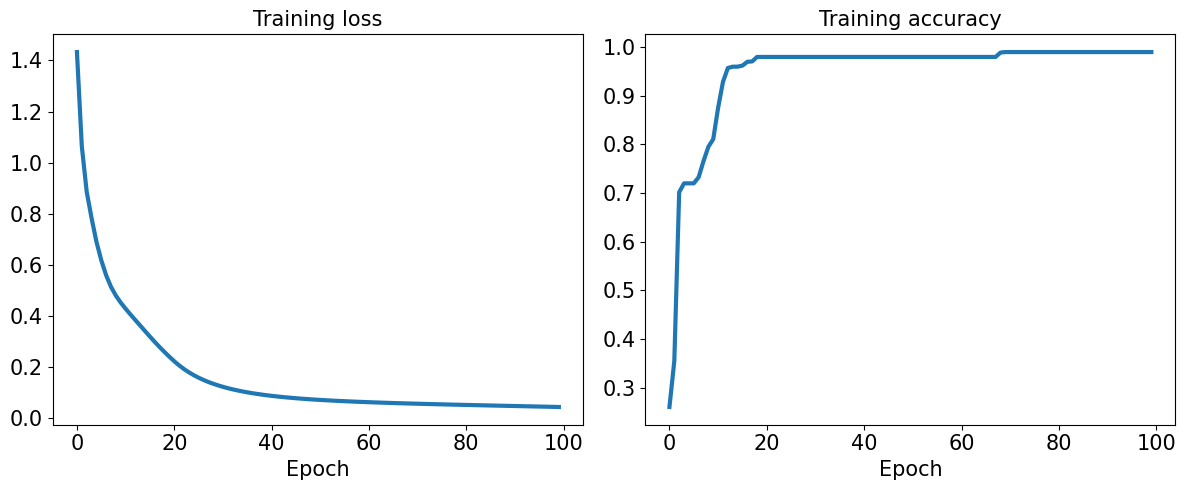

In [14]:
hist = history.history
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist["loss"], lw=3)
ax.set_title("Training loss", size=15)
ax.set_xlabel("Epoch", size=15)
ax.tick_params(axis="both", which="major", labelsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(hist["accuracy"], lw=3)
ax.set_title("Training accuracy", size=15)
ax.set_xlabel("Epoch", size=15)
ax.tick_params(axis="both", which="major", labelsize=15)
plt.tight_layout()
plt.show()

### 13.4.5 訓練したモデルをテストデータセットで評価する

In [15]:
results = iris_model.evaluate(ds_test.batch(50), verbose=0)
print("Test loss: {:.4f} Test Acc.: {:.4f}".format(*results))

Test loss: 0.0564 Test Acc.: 0.9800


### 13.4.6 訓練したモデルの保存と読み込み

In [16]:
iris_model.save("iris-classifier.h5",
               overwrite=True,
               include_optimizer=True,
               save_format="h5")

In [17]:
iris_model_new = tf.keras.models.load_model("iris-classifier.h5")

In [18]:
results = iris_model_new.evaluate(ds_test.batch(50), verbose=0)
print("Test loss: {:.4f} Test Acc.: {:.4f}".format(*results))

Test loss: 0.0564 Test Acc.: 0.9800


## 13.5 多層ニューラルネットワークでの活性化関数の選択

隠れ層の活性化関数として**双曲線正接関数**がよく使われる<br>
例えば、シグモイド関数が0に近い出力を返す場合、ニューラルネットワークの学習に非常に時間がかかり、訓練の際に極小値に至る可能性が高くなるため

### 13.5.1 ロジスティック関数のまとめ

ロジスティック関数を利用すれば、二値分類タスクにおいてデータ点$x$が陽性クラス（クラス1）に分類される確率をモデル化できる

ロジスティック（シグモイド）関数は次のように計算される<br>
$$
\phi_{logistic}{(z)} = \frac{1}{1+e^{-z}}
$$

$$
z = w_{0}x_{0} + w_{1}x_{1} + ... + w_{m}x_{m} = \mathbf{w^{T}x}
$$

In [2]:
import numpy as np
X = np.array([1, 1.4, 2.5])
w = np.array([0.4, 0.3, 0.5])
def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print("P(y=1|x) = %.3f" % logistic_activation(X, w))

P(y=1|x) = 0.888


このコードでは、総入力($z$)を共有し、それらの特徴量の値と重み係数を使ってロジスティックニューロンを活性化すると、0.888の値が返される。<br>
データ点$x$が陽性クラスに属する確率は88.8%であると解釈できる。

In [3]:
W = np.array([[1.1, 1.2, 0.8, 0.4],
            [0.2, 0.4, 1.0, 0.2],
            [0.6, 1.5, 1.2, 0.7]])
A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)
print("Net Input: \n", y_probas)
print("Output Units: \n", y_probas)

Net Input: 
 [0.85569687 0.68135373 0.83889105]
Output Units: 
 [0.85569687 0.68135373 0.83889105]


値を合計しても1にならないため、3クラス問題の所属確率として解釈できない。<br>
得られた出力ユニットからクラスラベルを予測する方法の1つは、最大値を与えるクラスラベルを予測値とすることである。

In [4]:
y_class = np.argmax(Z, axis=0)
print("Predicted class label: %d" % y_class)

Predicted class label: 0


状況によっては、多クラス分類の予測値として、各クラスの所属確率を計算すると有益かもしれない。<br>
次項では、ロジスティック関数の一般化であるソフトマックス関数を取り上げる。<br>
ソフトマックス関数は、多クラス分類のタスクに活用できる。

### 13.5.2 ソフトマックス関数を使って多クラス分類の所属確率を推定する

ソフトマックス関数では、総入力$z$のデータ点が$i$番目のクラスに分類される確率を計算できる。

$$
P(z)=\phi(z)=\frac{e^{z_{i}}}{\Sigma^{M}_{i=1} e^{z_{i}}}
$$

ソフトマックス関数をPythonで実装し、その効果を確かめよう。

In [5]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print("Probabilities:\n", y_probas)

Probabilities:
 [0.44668973 0.16107406 0.39223621]


In [6]:
np.sum(y_probas)

1.0

TensorFlowで多クラス分類モデルを構築するときは、`tf.keras.activations.softmax`関数を使って入力データが各クラスに所属する確率を推定できる。

In [7]:
import tensorflow as tf
Z_tensor = tf.expand_dims(Z, axis=0)
tf.keras.activations.softmax(Z_tensor)

2024-12-12 11:24:11.683547: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[0.44668973, 0.16107406, 0.39223621]])>

### 13.5.3 双曲線正接関数を使って出力範囲を拡大する

双曲線正接関数については、ロジスティック関数の尺度を取り直したバージョンと解釈できる。

ロジスティック関数に対する双曲線正接関数の利点は、出力範囲が広く、開区間$(-1, 1)$に及ぶことである。このため、バックプロパゲーションアルゴリズムの収束を改善することが可能である。

2つのシグモイド関数をプロットしてみよう。

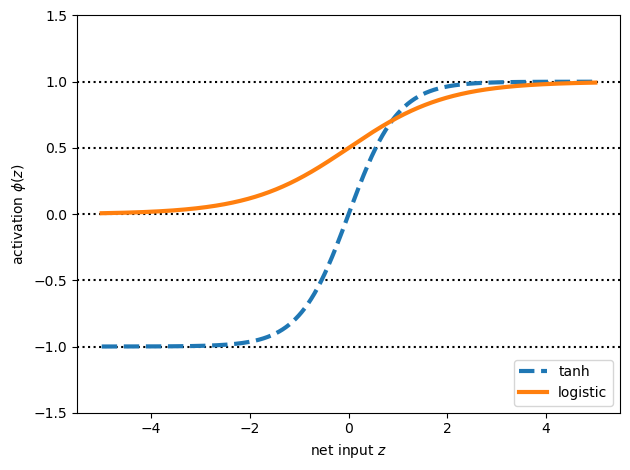

In [8]:
import matplotlib.pyplot as plt

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel("net input $z$")
plt.ylabel("activation $\phi(z)$")
plt.axhline(1, color="black", linestyle=":")
plt.axhline(0.5, color="black", linestyle=":")
plt.axhline(0, color="black", linestyle=":")
plt.axhline(-0.5, color="black", linestyle=":")
plt.axhline(-1, color="black", linestyle=":")
plt.plot(z, tanh_act, linewidth=3, linestyle="--", label="tanh")
plt.plot(z, log_act, linewidth=3, label="logistic")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [9]:
np.tanh(z)

array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])

In [10]:
tf.keras.activations.tanh(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=
array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])>

In [11]:
from scipy.special import expit
expit(z)

array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])

In [12]:
tf.keras.activations.sigmoid(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=
array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])>

### 13.5.4 ReLU活性化関数

**ReLU**は、ディープニューラルネットワークでよく使われる活性化関数である。

$$
\phi(z) = \mathrm{max}(0, z)
$$

In [13]:
tf.keras.activations.relu(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=array([0.   , 0.   , 0.   , ..., 4.985, 4.99 , 4.995])>

次章では、多層畳み込みニューラルネットワークの活性化関数としてReLUを使う。